# Training CIFAR-10 on a small CNN

https://arxiv.org/pdf/1412.6806.pdf

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models

from datetime import datetime
import cv2

In [2]:
import os
from tqdm import tqdm_notebook

In [3]:
PATH = Path("/data2/yinterian/data/")

## Import data from torchvision

If no transforms are provided, torchvision returns PIL objects. </br>

Here is some info about this dataset.
https://www.cs.toronto.edu/~kriz/cifar.html

In [4]:
train_set = datasets.CIFAR10(root=PATH/'cifardata', 
                                         train=True, download=True)
test_set = datasets.CIFAR10(root=PATH/'cifardata', 
                                        train=False, download=True)
test_set, valid_set = torch.utils.data.random_split(test_set,(5000,5000))

Files already downloaded and verified
Files already downloaded and verified


In [5]:
x, y = train_set[200]
y

6

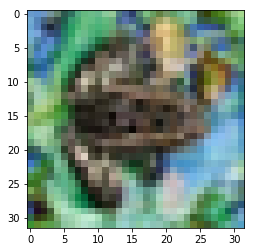

In [6]:
plt.imshow(x)

In [7]:
x = np.array(x)
x.shape

(32, 32, 3)

In [8]:
pad = 4
x = cv2.copyMakeBorder(x, pad, pad, pad, pad, cv2.BORDER_REFLECT)

(40, 40, 3)

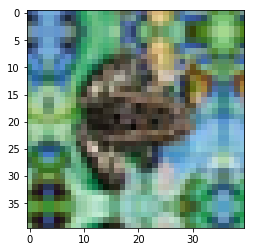

In [9]:
plt.imshow(x)
x.shape

## Preprocessing 

In [10]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

## Random transforms

In [11]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=4):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=4):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## Dataset

In [12]:
class CIFAR10(Dataset):
    """
    Basic Images DataSet
    Args:
        dataset: dataset with data
        transform: True for training otherwise False
    """

    def __init__(self, dataset, transform=False):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, y = self.dataset[index]
        x = np.array(img) / 255
        if self.transform:
            pad = 4
            x = cv2.copyMakeBorder(x, pad, pad, pad, pad, cv2.BORDER_REFLECT)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        
        return np.rollaxis(x, 2), y

    def __len__(self):
        return len(self.dataset)

In [13]:
train_ds = CIFAR10(train_set, transform=True)
valid_ds = CIFAR10(valid_set)
test_ds = CIFAR10(test_set)

In [14]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size,  shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [15]:
x, y = train_ds[0]
x.shape

(3, 32, 32)

In [16]:
x, y = valid_ds[0]
x.shape

(3, 32, 32)

## Model 

AllConvNet is taken from the paper https://arxiv.org/pdf/1412.6806.pdf. It is a all convolution network that replaces max_pooling with stride2 convolutions. I added Batchnorm to every layer.

In [36]:
class AllConvNet(nn.Module):
    def __init__(self, nc=3, n_classes=10, **kwargs):
        super(AllConvNet, self).__init__()
        self.conv1 = nn.Conv2d(nc, 96, 3, padding=1)
        self.conv2 = nn.Conv2d(96, 96, 3, padding=1)
        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2)
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1)
        self.conv5 = nn.Conv2d(192, 192, 3, padding=1)
        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2)
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1)
        self.conv8 = nn.Conv2d(192, 192, 1)

        self.bn1 = nn.BatchNorm2d(96)
        self.bn2 = nn.BatchNorm2d(96)
        self.bn3 = nn.BatchNorm2d(96)
        self.bn4 = nn.BatchNorm2d(192)
        self.bn5 = nn.BatchNorm2d(192)
        self.bn6 = nn.BatchNorm2d(192)
        self.bn7 = nn.BatchNorm2d(192)
        self.bn8 = nn.BatchNorm2d(192)
        self.bn9 = nn.BatchNorm2d(n_classes)
        
        self.class_conv = nn.Conv2d(192, n_classes, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))

        class_out = F.relu(self.bn9(self.class_conv(x)))
        pool_out = F.adaptive_avg_pool2d(class_out, 1)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out

In [18]:
model = AllConvNet().cuda()

In [19]:
x,y = next(iter(train_dl))
x = x.float().cuda()
y = y.cuda()

In [20]:
# soft predictions
pred = model(x)
pred

tensor([[0.4549, 0.0112, 0.3108, 0.3592, 0.1911, 0.0338, 0.1832, 0.3288, 0.1503,
         0.2546],
        [0.4156, 0.0038, 0.2153, 0.2683, 0.1153, 0.0302, 0.0793, 0.2106, 0.1650,
         0.4426],
        [0.2204, 0.0155, 0.2150, 0.5736, 0.2299, 0.0514, 0.1514, 0.4115, 0.1768,
         0.3634],
        [0.2561, 0.0163, 0.4084, 0.4103, 0.2601, 0.0684, 0.1718, 0.5147, 0.1201,
         0.2443],
        [0.4590, 0.0129, 0.2650, 0.3151, 0.1420, 0.0394, 0.0928, 0.2591, 0.1957,
         0.3898]], device='cuda:0', grad_fn=<SqueezeBackward3>)

In [21]:
# hard predcitions
_, hard_pred = torch.max(pred, 1)
hard_pred.shape

torch.Size([5])

In [22]:
F.cross_entropy(pred, y).item()

2.3473851680755615

In [23]:
# correctly classified
(hard_pred == y).sum()

tensor(0, device='cuda:0')

## Metric: accuracy

In [24]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size,  shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [25]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        pred = model(x)
        loss = F.cross_entropy(pred, y)
        _, hard_pred = torch.max(pred, 1)
        correct += (hard_pred == y).sum()
        sum_loss += batch*(loss.item())
        total += batch
    
    return sum_loss/total, correct.item()/total

In [26]:
val_metric(model, valid_dl)

(2.3026155643463135, 0.1014)

## Training functions

In [27]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

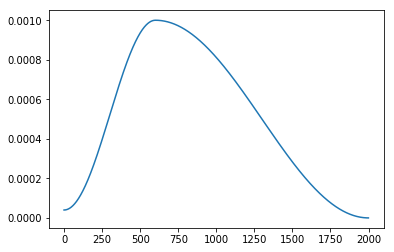

In [28]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [29]:
def create_optimizer(model, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return optimizer

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [30]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_auc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            update_optimizer(optimizer, lrs[idx])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % 
              (train_loss, val_loss, val_acc))
    return sum_loss/total

In [31]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    optimizer = create_optimizer(model, lrs[0])
    model.train()
    ind = 0
    prev_loss = 0
    for i in range(epochs):
        for x,y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, lr)
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append((prev_loss + loss.item())/2)
            prev_loss = loss.item()
            ind +=1
            
    load_model(model, str(p))
    return lrs[1:], losses[1:]

In [32]:
model = AllConvNet().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_high=0.5)

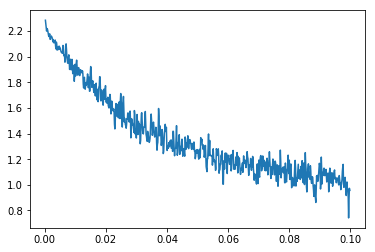

In [33]:
plt.plot(lrs, losses)
plt.show()

## Run Training

Note that in the original paper the authors trained for 350 epochs. We obtain the same results with 25 epochs.

In [34]:
model = AllConvNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.1, epochs = 8)

train_loss 1.692 val_loss 1.864 val_acc 0.392
train_loss 1.171 val_loss 2.106 val_acc 0.394
train_loss 0.944 val_loss 1.200 val_acc 0.601
train_loss 0.764 val_loss 0.740 val_acc 0.738
train_loss 0.635 val_loss 0.597 val_acc 0.803
train_loss 0.519 val_loss 0.523 val_acc 0.828
train_loss 0.435 val_loss 0.416 val_acc 0.859
train_loss 0.377 val_loss 0.393 val_acc 0.867


0.3772989624118805

In [215]:
model = AllConvNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 8)

train_loss 1.704 val_loss 1.982 val_acc 0.362
train_loss 1.137 val_loss 1.167 val_acc 0.606
train_loss 0.822 val_loss 0.942 val_acc 0.679
train_loss 0.634 val_loss 0.795 val_acc 0.733
train_loss 0.524 val_loss 0.606 val_acc 0.796
train_loss 0.418 val_loss 0.409 val_acc 0.866
train_loss 0.339 val_loss 0.340 val_acc 0.888
train_loss 0.286 val_loss 0.326 val_acc 0.891


0.2862458397483826

In [35]:
model = AllConvNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.1, epochs = 15)

train_loss 1.666 val_loss 2.448 val_acc 0.299
train_loss 1.138 val_loss 1.301 val_acc 0.558
train_loss 0.941 val_loss 0.998 val_acc 0.661
train_loss 0.796 val_loss 0.955 val_acc 0.674
train_loss 0.675 val_loss 0.785 val_acc 0.724
train_loss 0.588 val_loss 0.675 val_acc 0.776
train_loss 0.528 val_loss 0.632 val_acc 0.790
train_loss 0.470 val_loss 0.533 val_acc 0.816
train_loss 0.423 val_loss 0.493 val_acc 0.835
train_loss 0.377 val_loss 0.406 val_acc 0.863
train_loss 0.324 val_loss 0.417 val_acc 0.857
train_loss 0.281 val_loss 0.331 val_acc 0.891
train_loss 0.233 val_loss 0.307 val_acc 0.901
train_loss 0.200 val_loss 0.296 val_acc 0.897
train_loss 0.187 val_loss 0.295 val_acc 0.900


0.18711638514518739

In [217]:
model = AllConvNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 15)

train_loss 1.845 val_loss 1.621 val_acc 0.529
train_loss 1.293 val_loss 1.523 val_acc 0.480
train_loss 0.908 val_loss 1.088 val_acc 0.634
train_loss 0.711 val_loss 0.935 val_acc 0.691
train_loss 0.596 val_loss 0.625 val_acc 0.791
train_loss 0.510 val_loss 0.526 val_acc 0.819
train_loss 0.445 val_loss 0.536 val_acc 0.822
train_loss 0.384 val_loss 0.603 val_acc 0.796
train_loss 0.342 val_loss 0.422 val_acc 0.862
train_loss 0.292 val_loss 0.347 val_acc 0.881
train_loss 0.247 val_loss 0.311 val_acc 0.895
train_loss 0.206 val_loss 0.291 val_acc 0.905
train_loss 0.168 val_loss 0.263 val_acc 0.913
train_loss 0.145 val_loss 0.257 val_acc 0.914
train_loss 0.133 val_loss 0.254 val_acc 0.916


0.13341955620765686

In [229]:
# with no dropout
# this has the same error as the paper
model = AllConvNet().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs = 25)

train_loss 1.917 val_loss 1.759 val_acc 0.496
train_loss 1.447 val_loss 1.294 val_acc 0.621
train_loss 1.024 val_loss 1.130 val_acc 0.635
train_loss 0.770 val_loss 0.963 val_acc 0.681
train_loss 0.637 val_loss 1.155 val_acc 0.641
train_loss 0.563 val_loss 0.711 val_acc 0.760
train_loss 0.502 val_loss 0.770 val_acc 0.735
train_loss 0.440 val_loss 0.503 val_acc 0.830
train_loss 0.399 val_loss 0.473 val_acc 0.840
train_loss 0.362 val_loss 0.471 val_acc 0.844
train_loss 0.331 val_loss 0.406 val_acc 0.868
train_loss 0.303 val_loss 0.374 val_acc 0.874
train_loss 0.271 val_loss 0.397 val_acc 0.874
train_loss 0.245 val_loss 0.362 val_acc 0.878
train_loss 0.217 val_loss 0.328 val_acc 0.890
train_loss 0.194 val_loss 0.307 val_acc 0.901
train_loss 0.167 val_loss 0.354 val_acc 0.885
train_loss 0.141 val_loss 0.294 val_acc 0.904
train_loss 0.116 val_loss 0.270 val_acc 0.912
train_loss 0.098 val_loss 0.265 val_acc 0.918
train_loss 0.082 val_loss 0.257 val_acc 0.920
train_loss 0.067 val_loss 0.251 va

0.05202201225042343

In [230]:
test_dl = DataLoader(test_ds, batch_size=128)

In [231]:
test_loss, test_acc = val_metric(model, test_dl)
print(test_loss, test_acc)

0.2208082773208618 0.9316


In [232]:
1-0.9316

0.06840000000000002

## Effect of Batchnorm
Create a new network without batchnorm and run similar experiments experiment.

## References
* https://arxiv.org/pdf/1412.6806.pdf
* https://discuss.pytorch.org/t/pytorch-net-from-striving-for-simplicity-the-all-convolutional-net/19297

### Example of AdaptiveAvgPool2d

In [46]:
ave_pool = nn.AdaptiveAvgPool2d((2,2))
x = torch.randn(1, 64, 8, 8)
ave_pool(x).shape

torch.Size([1, 64, 2, 2])

In [47]:
ave_pool = nn.AdaptiveAvgPool2d((1,1))
x = torch.randn(1, 64, 8, 9)
ave_pool(x).shape

torch.Size([1, 64, 1, 1])

In [48]:
ave_pool = nn.AdaptiveAvgPool2d((1))
x = torch.randn(1, 64, 8, 9)
ave_pool(x).shape

torch.Size([1, 64, 1, 1])

In [49]:
ave_pool = nn.AdaptiveAvgPool2d((1,1))
x = torch.randn(1, 64, 20, 50)
ave_pool(x).shape

torch.Size([1, 64, 1, 1])